# **Transformer Applications**

In [1]:
import torchtext
import torch
import torch.nn as nn
from torch.nn import functional as F

### **Transformer-Encoder**

#### **Token and Positional Embedding**

In [2]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

#### **Transformer-Encoder Block**

In [3]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

#### **Transformer-Encoder**

In [12]:
class TransformerEncoder(nn.Module):
    def __init__(self, src_vocab_size, embed_dim, max_length, num_layer, 
                 num_heads, ff_dim, dropout=0.1, device="cpu"):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(src_vocab_size, embed_dim, max_length, device)
        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(
                    embed_dim, num_heads, ff_dim, dropout
                ) for _ in range(num_layer)
            ]
        )
    
    def forward(self, x):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, output, output)
        return output


In [13]:
batch_size = 32
src_vocab_size = 1000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

In [14]:
input = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [15]:
input

tensor([[0, 1, 1,  ..., 1, 0, 1],
        [1, 1, 1,  ..., 0, 1, 1],
        [0, 0, 1,  ..., 1, 0, 1],
        ...,
        [1, 1, 0,  ..., 1, 0, 1],
        [1, 1, 1,  ..., 1, 0, 1],
        [0, 0, 1,  ..., 1, 1, 0]])

In [16]:
encoder = TransformerEncoder(
    src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim
)

In [17]:
encoded = encoder(input)

In [18]:
encoded.shape

torch.Size([32, 100, 200])

### **Transformer-Decoder**

#### **Transformer Decoder Block**

In [19]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_3 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.dropout_3 = nn.Dropout(p=dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output, _ = self.attn(x, x, x, attn_mask=tgt_mask)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(x + attn_output)

        attn_output, _ = self.cross_attn(
            out_1, enc_output, enc_output, attn_mask=src_mask
        )
        attn_output = self.dropout_2(attn_output)
        out_2 = self.layernorm_2(out_1 + attn_output)

        ffn_output = self.ffn(out_2)
        ffn_output = self.dropout_2(ffn_output)
        out_3 = self.layernorm_2(out_2 + ffn_output)
        return out_3

#### **Transformer-Decoder**

In [20]:
class TransformerDecoder(nn.Module):
    def __init__(self, tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim,
                 dropout=0.1, device="cpu"):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(tgt_vocab_size, embed_dim, max_length, device)
        self.layers = nn.ModuleList(
            [
                TransformerDecoderBlock(
                    embed_dim, num_heads, ff_dim, dropout
                ) for _ in range(num_layers)
            ]
        )
    
    def forward(self, x, enc_output, src_mask, tgt_mask):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, enc_output, src_mask, tgt_mask)
        return output

### **Transformer**

In [21]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim, max_length, num_layers,
                 num_heads, ff_dim, dropout=0.1, device="cpu"):
        super().__init__()
        self.device = device
        self.encoder = TransformerEncoder(src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim)
        self.decoder = TransformerDecoder(tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim)
        self.fc = nn.Linear(embed_dim, tgt_vocab_size)
    
    def generate_mask(self, src, tgt):
        src_seq_len = src.shape[1]
        tgt_seq_len = tgt.shape[1]
        
        src_mask = torch.zeros(
            (src_seq_len, src_seq_len),
            device=self.device
        ).type(torch.bool)
        
        tgt_mask = (
            torch.triu(
                torch.ones((tgt_seq_len, tgt_seq_len), device=self.device)
            ) == 1 
        ).transpose(0, 1)
        
        tgt_mask = tgt_mask.float().masked_fill(
            tgt_mask == 0, float("-inf")
        ).masked_fill(tgt_mask == 1, float(0.0))
        
        return src_mask, tgt_mask
    
    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        enc_output = self.encoder(src)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        output = self.fc(dec_output)
        return output

In [22]:
batch_size = 128
src_vocab_size = 1000
tgt_vocab_size = 2000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

In [23]:
model = Transformer(
    src_vocab_size, tgt_vocab_size,
    embed_dim, max_length, num_layers, num_heads, ff_dim
)

In [24]:
src = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [25]:
src

tensor([[0, 0, 0,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 0, 1, 0],
        [1, 0, 1,  ..., 1, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 0, 1],
        [0, 1, 1,  ..., 1, 1, 0]])

In [26]:
tgt = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [27]:
prediction = model(src, tgt)

In [28]:
prediction.shape

torch.Size([128, 100, 2000])

# **Text Classification using Transformer-Encoder**

### **Load Dataset**

In [29]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ------- -------------------------------- 5.0/25.1 MB 37.7 MB/s eta 0:00:01
   ----------------------- ---------------- 14.7/25.1 MB 35.5 MB/s eta 0:00:01
   ---------------------------------------  24.9/25.1 MB 41.5 MB/s eta 0:00:01
   ---------------------------------------  24.9/25.1 MB 41.5 MB/s eta 0:00:01
   ---------------------------------------- 25.1/25.1 MB 25.7 MB/s eta 0:00:00


In [30]:
from datasets import load_dataset

ds = load_dataset('thainq107/ntc-scv')

README.md:   0%|          | 0.00/570 [00:00<?, ?B/s]

C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ADMIN\.cache\huggingface\hub\datasets--thainq107--ntc-scv. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/6.35M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/6.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [31]:
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
})

### **Preprocessing**

**Text Cleaning**

In [32]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

### **Representation**

In [33]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [34]:
# word-based tokenizer
import torchtext
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [35]:
ds['train']['preprocessed_sentence'][0]

'cửa hàng nhỏ xinh trên mặt đường vị trí khá dễ tìm đồ ăn ngon giá phải chăng bánh mỳ chảo cười bánh mỳ sốt vang và xúc xích cùng sữa ngô nữa hết có k qúa ổn luôn'

In [36]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(ds['train']['preprocessed_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [37]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for row in df:
        sentence = row['preprocessed_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(ds['train'])
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(ds['valid'])
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(ds['test'])
test_dataset = to_map_style_dataset(test_dataset)

In [38]:
for row in ds['train']:
    print(vocabulary(tokenizer(row['preprocessed_sentence'])))
    break

[351, 111, 112, 529, 124, 228, 196, 53, 159, 43, 103, 256, 46, 2, 11, 31, 52, 723, 32, 491, 991, 533, 32, 491, 220, 1415, 9, 731, 897, 185, 130, 836, 57, 88, 4, 14, 3183, 251, 59]


### **Dataloader**

In [39]:
import torch

seq_length = 100

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0]* (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [40]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [41]:
next(iter(train_dataloader))

(tensor([[  38,    7,  119,  ...,    0,    0,    0],
         [   7,  298,  205,  ...,    0,    0,    0],
         [   7,  415,  764,  ...,    0,    0,    0],
         ...,
         [  10, 2212, 1454,  ...,    0,    0,    0],
         [1931,    8, 1786,  ...,   32,   30,   49],
         [1555, 1172,    9,  ...,    0,    0,    0]]),
 tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
         1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
         1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
         0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
         0, 0, 0, 1, 0, 1, 0, 0]))

In [42]:
len(train_dataloader)

235

In [43]:
encoded_sentences, labels = next(iter(train_dataloader))

In [44]:
encoded_sentences.shape

torch.Size([128, 100])

In [45]:
labels.shape

torch.Size([128])

### **Trainer**

In [46]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [47]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [48]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt', weights_only=True))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [49]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

### **Modeling**

In [50]:
class TransformerEncoderCls(nn.Module):
    def __init__(self, vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout=0.1, device="cpu"):
        super().__init__()
        self.encoder = TransformerEncoder(vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device)
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.encoder(x)
        output = self.pooling(output.permute(0, 2, 1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [51]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout=0.1

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout
)

In [52]:
encoded_sentences.shape

torch.Size([128, 100])

In [53]:
predictions = model(encoded_sentences)

In [54]:
predictions.shape

torch.Size([128, 2])

In [55]:
predictions

tensor([[-2.4601e-01, -9.6225e-02],
        [-2.3405e-01, -1.4820e-01],
        [-3.7788e-01,  1.2449e-01],
        [-2.1063e-01, -4.6185e-02],
        [-4.1322e-01,  2.4215e-01],
        [-3.0247e-01, -1.2871e-02],
        [-2.5339e-01, -1.2098e-01],
        [-4.2597e-01,  1.8238e-01],
        [-2.1496e-01, -1.0332e-01],
        [-3.3915e-01,  2.8413e-02],
        [-3.5932e-01, -3.8415e-02],
        [-5.2375e-01,  1.6713e-01],
        [-4.9380e-01,  3.1171e-01],
        [-3.1480e-01,  1.6667e-01],
        [-4.8204e-01,  7.1993e-02],
        [-2.3121e-01, -5.1912e-02],
        [-3.1386e-01, -5.0327e-02],
        [-3.6747e-01,  1.9123e-04],
        [-5.2193e-01,  2.4157e-01],
        [-3.9742e-01,  1.0556e-01],
        [-5.7176e-01,  9.4149e-02],
        [-5.4426e-01,  1.0920e-01],
        [-2.5193e-01, -5.5993e-02],
        [-4.6976e-01,  2.2014e-01],
        [-5.9050e-01,  3.0563e-01],
        [-3.9006e-01,  1.6503e-01],
        [-4.9771e-01,  3.1831e-01],
        [-3.2763e-01, -6.521

### **Training**

In [56]:
import os
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout, device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  235 batches | accuracy    0.537
| epoch   1 |   100/  235 batches | accuracy    0.590
| epoch   1 |   150/  235 batches | accuracy    0.666
| epoch   1 |   200/  235 batches | accuracy    0.712
-----------------------------------------------------------
| End of epoch   1 | Time: 263.37s | Train Accuracy    0.743 | Train Loss    0.639 | Valid Accuracy    0.752 | Valid Loss    0.534 
-----------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy    0.762
| epoch   2 |   100/  235 batches | accuracy    0.776
| epoch   2 |   150/  235 batches | accuracy    0.788
| epoch   2 |   200/  235 batches | accuracy    0.796
-----------------------------------------------------------
| End of epoch   2 | Time: 263.69s | Train Accuracy    0.801 | Train Loss    0.473 | Valid Accuracy    0.796 | Valid Loss    0.449 
-----------------------------------------------------------
| epoch   3 |    50/  235 batches | accuracy    0.803
| epoch   

C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


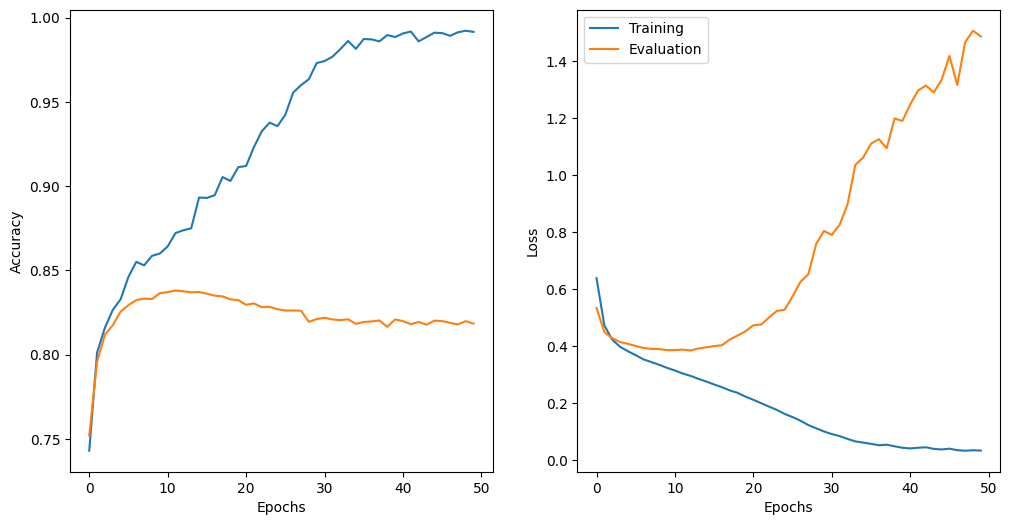

In [57]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [58]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.8193, 1.4528388479087926)